# **Análisis de amenaza por contaminación atmosférica**   
En este notebook se realiza el analisis por contaminación atmosferica, teniendo como insumo las concentraciones de material particulado PM2.5.    
Este es clasificado en niveles de amenaza (baja, moderada y alta)

Inicialmente se importan las librerias

In [93]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from pykrige.ok import OrdinaryKriging
import os
from rasterio.transform import from_origin
import rasterio

**Preparación de datos**   
En la siguiente celda se lleva a cabo el cargue y preparación de la información a necesitar en el transcurso del proyecto.

In [94]:
root_folder=r"/notebooks/Proyecto/Datos"

# Leer todos los datos
dat_con = root_folder+r"/data_MAR_1.csv"
Coor_est = root_folder+r"/Coordenadas_Est.xlsx"
Municipio = root_folder+r"/Soacha.shp"

# Leer el archivo CSV de los datos de concentración
PM2_5 = pd.read_csv(dat_con)
print(PM2_5.head(2))

# Leer el archivo XLSX de las coordenadas de estaciones y convertirlo a un GeoDataFrame
Est = pd.read_excel(Coor_est)
geometria = [Point(xy) for xy in zip(Est["Longitud"], Est["Latitud"])]
Estaciones = gpd.GeoDataFrame(Est, geometry=geometria, crs="epsg:4326")
Estaciones = Estaciones.to_crs(epsg=9377)
print("CRS Estaciones:" , Estaciones.crs)
Estaciones = Estaciones.drop(index=2)
Estaciones = Estaciones.drop(index=13)
print(Estaciones)

# Leer el archivo shapefile del municipio de Soacha
Soacha = gpd.read_file(Municipio)
Soacha = Soacha.to_crs(epsg=9377)
print("CRS Municipio de Soacha:", Soacha.crs)              
print(Soacha.head())

                   date    PM25  Humidity  Temperature  \
0  2025-03-01T01:00:00Z  17.745    77.936        18.17   
1  2025-03-01T02:00:00Z  18.760    78.760        18.00   

                     station  
0  SAM_IE_BuenosAires_306e73  
1  SAM_IE_BuenosAires_306e73  
CRS Estaciones: EPSG:9377
                          Estación   Latitud   Longitud  \
0        SAM_IE_BuenosAires_306e73  4.565259 -74.188092   
1             SAM_IE_Cazuca_7f4c00  4.587222 -74.187710   
3         SAM_IE_ElProgreso_1c4cc9  4.568374 -74.186814   
4   SAM_IE_GeneralSantander_edee42  4.584938 -74.218339   
5         SAM_IE_LaDespensa_7c0276  4.595552 -74.187509   
6           SAM_IE_LeonXIII_fb3f2c  4.593887 -74.194362   
7     SAM_IE_NuevoCompartir_fc04d7  4.572743 -74.242183   
8      SAM_IE_PazyEsperanza_f36757  4.578765 -74.234432   
9             SAM_IE_Chiloe_6eeafa  4.604524 -74.213812   
10       SAM_IE_ElCharquito_3075d1  4.544090 -74.275430   
11           SAM_IE_Fusunga_4d410c  4.537200 -74.202020  

**Análisis de datos**   
En la siguiente celda se lleva a cabo el calculo de la mediana para cada día de la semana (lunes, martes, miercoles, jueves, viernes, sabado y domingo)

In [95]:
# Extraer el nombre del día de la semana
PM2_5["date"] = pd.to_datetime(PM2_5["date"])
PM2_5["Dia"] = PM2_5["date"].dt.day_name()

print(PM2_5.head(2))

                       date    PM25  Humidity  Temperature  \
0 2025-03-01 01:00:00+00:00  17.745    77.936        18.17   
1 2025-03-01 02:00:00+00:00  18.760    78.760        18.00   

                     station       Dia  
0  SAM_IE_BuenosAires_306e73  Saturday  
1  SAM_IE_BuenosAires_306e73  Saturday  


In [96]:
# Calcular la mediana de PM2.5 para cada día de la semana
Mediana_PM25 = (PM2_5.groupby(["station", "Dia"])["PM25"].median().unstack(fill_value=0))
Dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
Mediana_PM25 = Mediana_PM25[Dias]
Mediana_PM25E = Mediana_PM25.reset_index()
print(Mediana_PM25E)
list(Mediana_PM25E.columns)

Dia                         station   Monday  Tuesday  Wednesday  Thursday  \
0         SAM_IE_BuenosAires_306e73  11.1385  13.6335    13.9585    6.5665   
1              SAM_IE_Cazuca_7f4c00  17.2750  25.4670    21.9835   16.5920   
2              SAM_IE_Chiloe_6eeafa  13.7305  16.8830    13.2170   10.3335   
3         SAM_IE_ElCharquito_3075d1  23.6415  17.2170    18.0580   17.1510   
4          SAM_IE_ElProgreso_1c4cc9  17.9170  27.4670    20.8000   17.5750   
5             SAM_IE_Fusunga_4d410c  12.5285  16.7830     9.9940   13.3750   
6    SAM_IE_GeneralSantander_edee42  16.7670  17.6500    16.0830   13.4810   
7          SAM_IE_LaDespensa_7c0276  12.2170  20.5170    19.2335   14.2085   
8            SAM_IE_LeonXIII_fb3f2c   8.0000  15.6570    18.0770   12.0835   
9     SAM_IE_LuisCarlosGalan_e38027  10.9730  15.0000    14.7500   14.6830   
10     SAM_IE_NuevoCompartir_fc04d7  14.7335  13.0950    12.4245   11.0000   
11      SAM_IE_PazyEsperanza_f36757  17.1000  18.7830    15.8000

['station',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday']

In [97]:
# Renombrar la columna "station" para que coincida con "Estación"
Mediana_PM25E["Estación"] = Mediana_PM25E["station"].str.strip()
Mediana_PM25E = Mediana_PM25E.drop(columns="station")
print(Mediana_PM25E.head())

Dia   Monday  Tuesday  Wednesday  Thursday   Friday  Saturday   Sunday  \
0    11.1385  13.6335    13.9585    6.5665  15.2670    13.100  13.1715   
1    17.2750  25.4670    21.9835   16.5920  20.5365    21.783  19.5500   
2    13.7305  16.8830    13.2170   10.3335  12.7330    14.288  14.2030   
3    23.6415  17.2170    18.0580   17.1510  24.4140    14.325  16.5670   
4    17.9170  27.4670    20.8000   17.5750  22.1330    22.342  22.6000   

Dia                   Estación  
0    SAM_IE_BuenosAires_306e73  
1         SAM_IE_Cazuca_7f4c00  
2         SAM_IE_Chiloe_6eeafa  
3    SAM_IE_ElCharquito_3075d1  
4     SAM_IE_ElProgreso_1c4cc9  


In [98]:
# Hacer el join espacial por nombre de estación
Est_PM25 = Estaciones.merge(Mediana_PM25E, on="Estación", how="left")
Est_PM25 = Est_PM25.drop(columns="Latitud")
Est_PM25 = Est_PM25.drop(columns="Longitud")
Est_PM25.to_file("Est_PM25.shp")
print("CRS Est_PM25:", Est_PM25.crs) 
print(Est_PM25)

CRS Est_PM25: EPSG:9377
                          Estación                         geometry   Monday  \
0        SAM_IE_BuenosAires_306e73   POINT (4868255.14 2062565.349)  11.1385   
1             SAM_IE_Cazuca_7f4c00   POINT (4868301.461 2064992.54)  17.2750   
2         SAM_IE_ElProgreso_1c4cc9  POINT (4868397.403 2062909.309)  17.9170   
3   SAM_IE_GeneralSantander_edee42  POINT (4864904.225 2064745.855)  16.7670   
4         SAM_IE_LaDespensa_7c0276  POINT (4868325.315 2065913.093)  12.2170   
5           SAM_IE_LeonXIII_fb3f2c  POINT (4867565.042 2065730.361)   8.0000   
6     SAM_IE_NuevoCompartir_fc04d7  POINT (4862257.633 2063402.584)  14.7335   
7      SAM_IE_PazyEsperanza_f36757  POINT (4863118.331 2064066.612)  17.1000   
8             SAM_IE_Chiloe_6eeafa  POINT (4865410.036 2066909.599)  13.7305   
9        SAM_IE_ElCharquito_3075d1  POINT (4858564.717 2060242.316)  23.6415   
10           SAM_IE_Fusunga_4d410c  POINT (4866705.275 2059466.906)  12.5285   
11   SAM_IE_Luis

**Interpolación de datos con el uso del Kriging**   
En la siguiente celda se lleva a cabo la interporlación de los datos para cada día de la semana (lunes, martes, miercoles, jueves, viernes, sabado y domingo) con el uso de Kriging

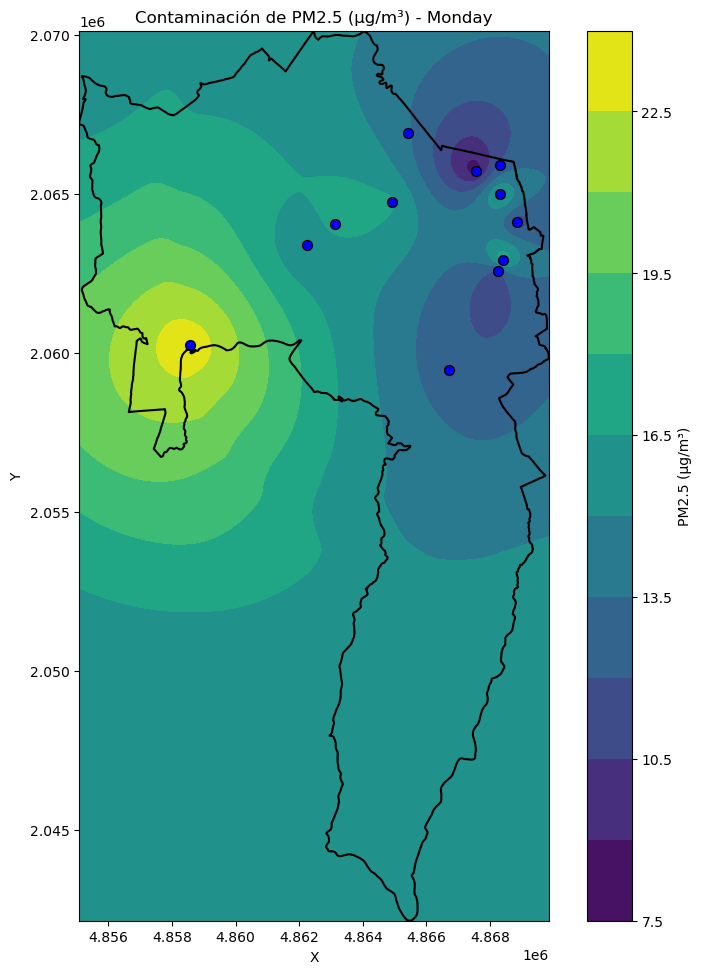

Monday: Raster y figura guardados correctamentte.


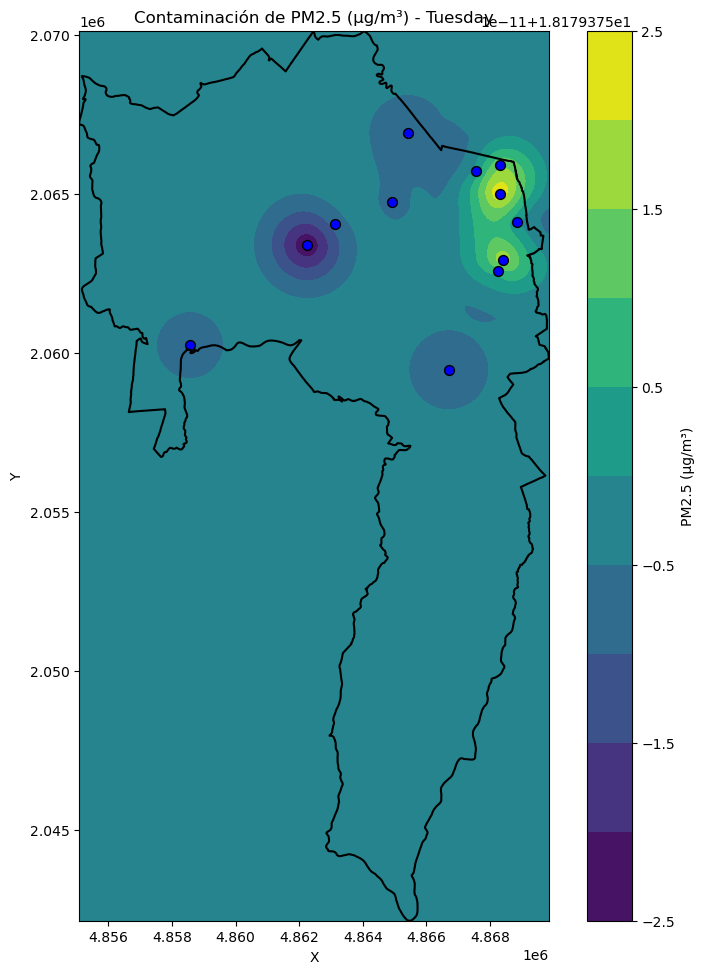

Tuesday: Raster y figura guardados correctamentte.


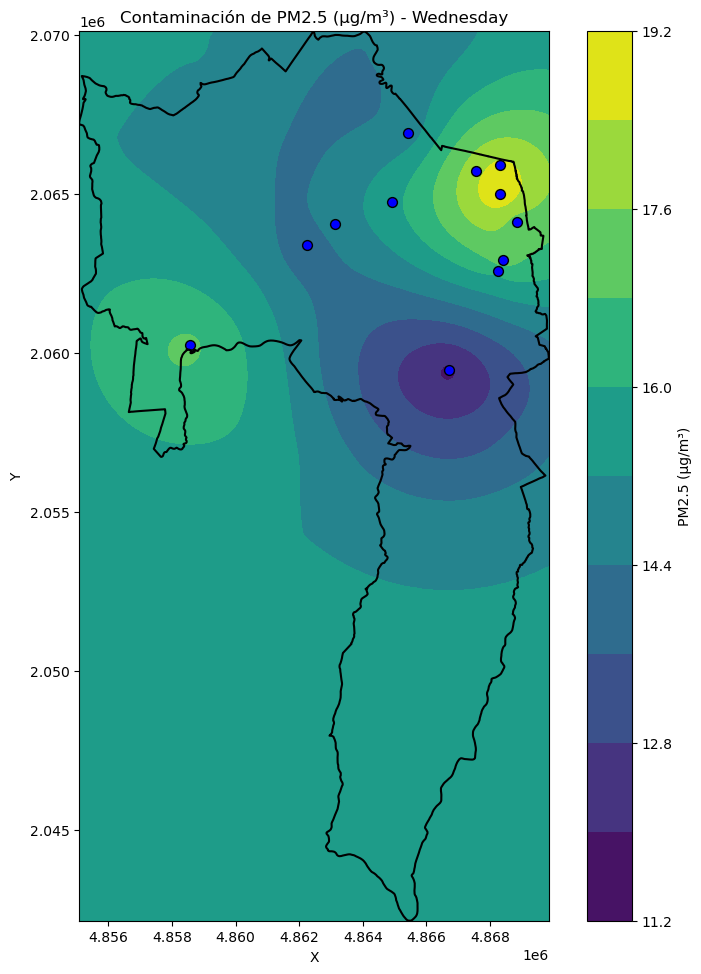

Wednesday: Raster y figura guardados correctamentte.


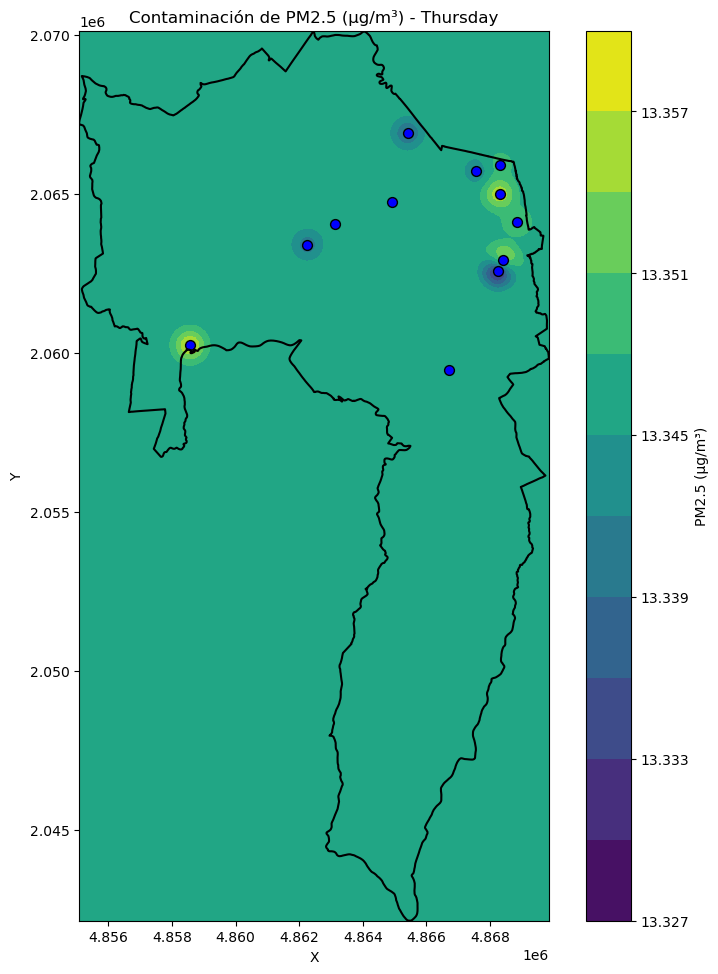

Thursday: Raster y figura guardados correctamentte.


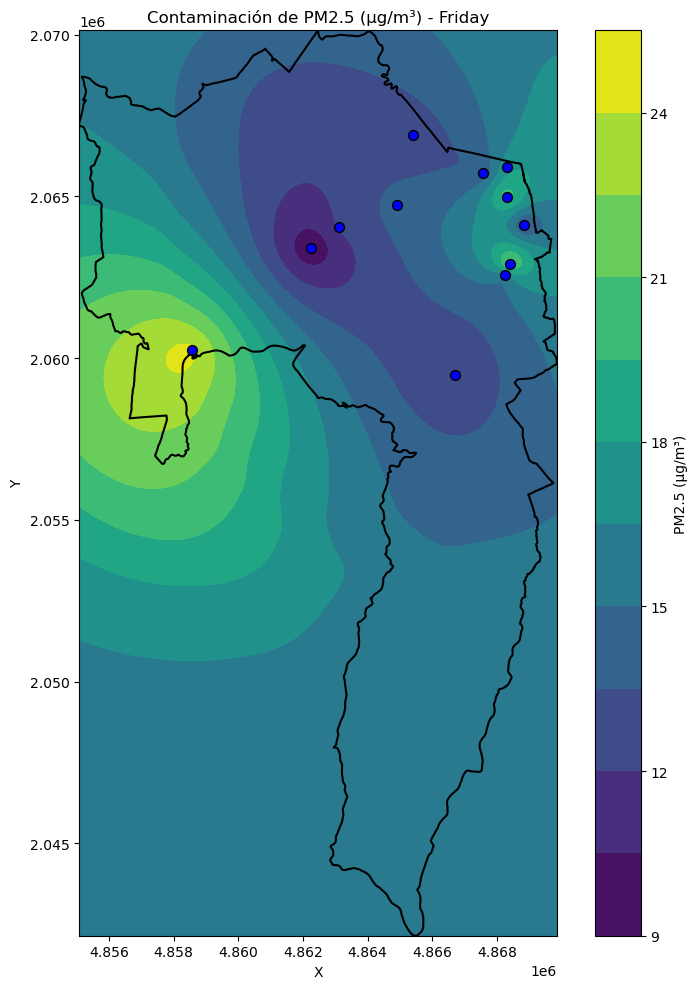

Friday: Raster y figura guardados correctamentte.


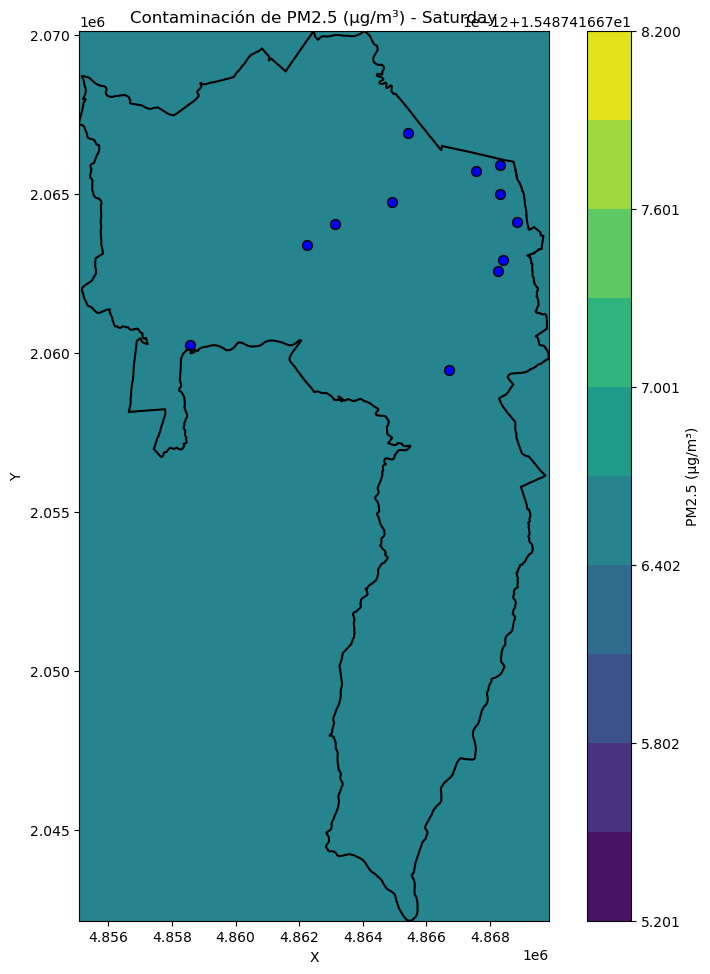

Saturday: Raster y figura guardados correctamentte.


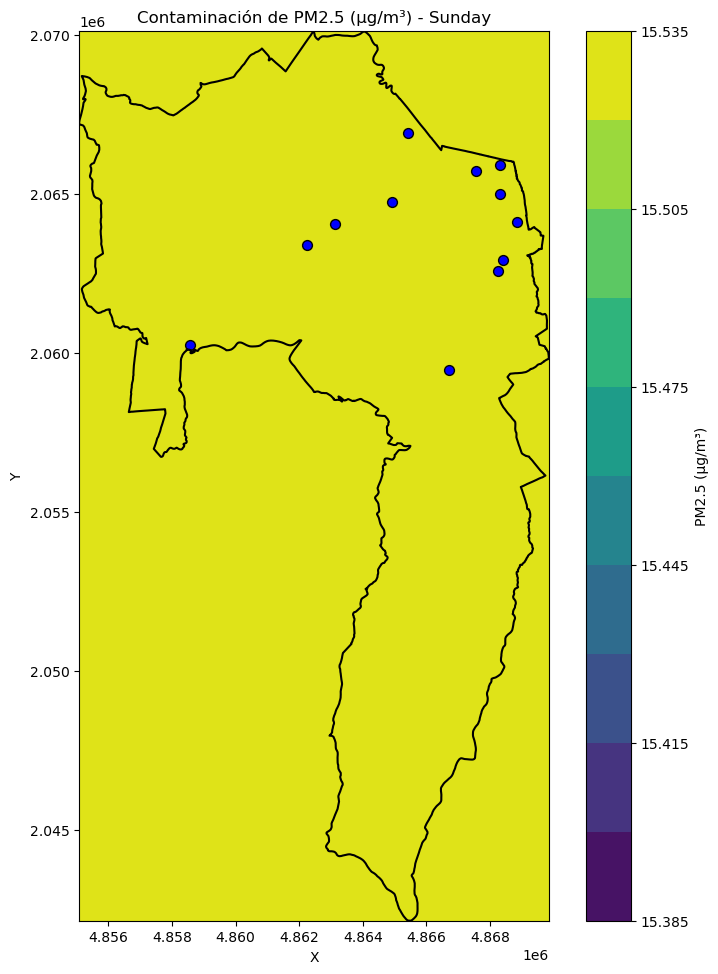

Sunday: Raster y figura guardados correctamentte.


In [105]:
# Realizar la interpolación Kriging para cada día de la semana

Extension = Soacha.total_bounds
res = 100

# Generar la malla para poder interpolar
xmin, ymin, xmax, ymax = Extension
Mallax = int((xmax - xmin) / res)
Mallay = int((ymax - ymin) / res)


xMalla = np.linspace(xmin, xmax, Mallax)
yMalla = np.linspace(ymin, ymax, Mallay)

transfor = from_origin(xmin, ymax, res, res)

# Definir los días de la semana 
DiasSemana = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] 

# Interpolar con el uso de Kriging y guardar los raster y figuras 
for dia in DiasSemana:
    x = Est_PM25.geometry.x.values
    y = Est_PM25.geometry.y.values
    z = Est_PM25[dia].values

    Kriging = OrdinaryKriging(x, y, z, variogram_model="spherical", verbose=False, enable_plotting=False)
    z_interp, ss = Kriging.execute("grid", xMalla, yMalla)

    z_interp = np.flipud(z_interp)

    with rasterio.open(
        f"/notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Amenaza_{dia}.tif",
        "w",
        driver = "GTiff",
        height=z_interp.shape[0],
        width=z_interp.shape[1],
        count=1,
        dtype='float32',
        crs=Est_PM25.crs,
        transform=transform,
    ) as dst:
        dst.write(z_interp.astype("float32"), 1)

    fig, ax = plt.subplots(figsize=(8,10))
    contour = ax.contourf(xMalla, yMalla, np.flipud(z_interp), cmap="viridis", levels=10)
    cbar = fig.colorbar(contour, ax=ax, label="PM2.5 (µg/m³)")
    
    Est_PM25.plot(ax=ax, color="blue", edgecolor="black", markersize=50)
    Soacha.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1.5)
      
    ax.set_title(f"Contaminación de PM2.5 (µg/m³) - {dia}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.tight_layout()
    plt.savefig(f"/notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Amenaza_{dia}.png", dpi=300)
    plt.show()

    print(f"{dia}: Raster y figura guardados correctamentte.")

**Reclasificar los raster de acuerdo a los siguientes valores de concentración de PM2.5**   
* 0 - 15 µg/m³ ---> Aceptable (1)
* 15 - 35 µg/m³ ---> Moderado (2)
* 35 - 50 µg/m³ ---> Malo (3)

In [106]:
# Definir ruta de entrada y salida de los raster clasificados
Entrada = "/notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster"
Salida = f"{Entrada}/Reclasificados"
os.makedirs(Salida, exist_ok=True)

# Definir la función de reclasificado
def reclasificar(array):
    
    reclasificado = np.where(array <= 15, 1,
                    np.where(array <= 35, 2,
                    np.where(array <= 50, 3, 0)))
    
    return reclasificado

for dia in DiasSemana:
    raster = os.path.join(Entrada, f"Amenaza_{dia}.tif")
    with rasterio.open(raster) as src:
        z_interp = src.read(1)
        meta = src.meta.copy()

    z_clasificado = reclasificar(z_interp)

    meta.update(dtype="uint8")

    reclass = os.path.join(Salida, f"Amenaza_{dia}_clasificado.tif")
    with rasterio.open(reclass, "w", **meta) as dst:
        dst.write(z_clasificado.astype("uint8"), 1)

    print(f"{dia}: raster clasificado guardado en {reclass}")


Monday: raster clasificado guardado en /notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Reclasificados/Amenaza_Monday_clasificado.tif
Tuesday: raster clasificado guardado en /notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Reclasificados/Amenaza_Tuesday_clasificado.tif
Wednesday: raster clasificado guardado en /notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Reclasificados/Amenaza_Wednesday_clasificado.tif
Thursday: raster clasificado guardado en /notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Reclasificados/Amenaza_Thursday_clasificado.tif
Friday: raster clasificado guardado en /notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Reclasificados/Amenaza_Friday_clasificado.tif
Saturday: raster clasificado guardado en /notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Reclasificados/Amenaza_Saturday_clasificado.tif
Sunday: raster clasificado guardado en /notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Reclasificados/Amenaza_Sunday